# Aplicando EDA al dataset Taxi Fare

Instalamos las dependencias necesarias para realizar el análisis

In [114]:
!pip install pandas
!pip install seaborn
!pip install tqdm

Importamos los módulos a utilizar posteriormente

```
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np

from multiprocessing import cpu_count, Pool
from math import radians, cos, sin, asin, sqrt
```

In [115]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

from multiprocessing import cpu_count, Pool
from math import radians, cos, sin, asin, sqrt

# Esto es solo para la visualización en Pycharm
sns.set_style("ticks")

sns

<module 'seaborn' from '/home/diego/Desktop/general_venv/lib/python3.9/site-packages/seaborn/__init__.py'>

Inicializamos algunas constantes a utilizar

* **FILE_PATH:** Contiene la ruta de nuestro dataset.
* **EARTH_RADIUS:** Es el valor promedio del radio de la Tierra en kilómetros.
* **CHUNK_SIZE:** Indica el tamaño del conjunto de datos que se procesará en cada iteración.
* **AVAILABLE_CPUS:** Tiene el número de threads que estarán disponibles en el uso de este cuaderno.
* **INITIAL_VALID_COLUMNS:** Tiene los nombres de las columnas que nos interesa cargar en memoria.

In [116]:
FILE_PATH = "train.csv"
EARTH_RADIUS = 6378.0  # Lo utilizamos en el cálculo de la fórmula de Haversine.
CHUNK_SIZE = 10000
AVAILABLE_CPUS = cpu_count() - 1  # Disminuimos uno del total para evitar que la pc se queda inutilizable.
INITIAL_VALID_COLUMNS = ['fare_amount',
                         'pickup_datetime',
                         'pickup_longitude',
                         'pickup_latitude',
                         'dropoff_longitude',
                         'dropoff_latitude',
                         'passenger_count'
                         ]

FILE_PATH, EARTH_RADIUS, CHUNK_SIZE, AVAILABLE_CPUS

('train.csv', 6378.0, 10000, 11)

## Fórmula Haversine

Esta fórmula nos servirá para poder calcular la distancia entre 2 puntos geográficos.

$d=2r\sin^{-1}{\left(\sqrt{\sin^{2}{\left(\frac{\phi_2-\phi_1}{2}\right)}+\cos{(\phi_1)}\cos{(\phi_2)}\sin^{2}{\left(\frac{\lambda_2-\lambda_1}{2}\right)} }\right)}$

Está fórmula será implementada en la función `calculate_haversine_distance`, la cual recibe una columna de tuplas con
los puntos de latitud y longitud tanto de la posición en **pickup** como en **drop off**.

In [117]:
def calculate_haversine_distance(pickup_position, drop_off_position):
    pickup_lat, pickup_lng = pickup_position
    drop_off_lat, drop_off_lng = drop_off_position

    pickup_lat, pickup_lng, drop_off_lat, drop_off_lng = map(
        radians,
        (pickup_lat, pickup_lng, drop_off_lat, drop_off_lng)
    )

    lat_diff = drop_off_lat - pickup_lat
    lng_diff = drop_off_lng - pickup_lng

    distance = sin(lat_diff * 0.5) ** 2 + cos(pickup_lat) * cos(drop_off_lat) * sin(lng_diff * 0.5) ** 2

    return 2 * EARTH_RADIUS * asin(sqrt(distance))

calculate_haversine_distance

<function __main__.calculate_haversine_distance(pickup_position, drop_off_position)>

## Procesamiento de la data

El dataset es enorme, tiene **55423857** registros sobre los precios de los taxis, dentro de este dataset tenemos casos
donde no existen ciertos registros, o donde tenemos valores bastante extraños, tales como precios negativos o registros
donde no existe ningún pasajero, estos registros pueden afectar enormemente los resultados de nuestro modelo, para ello
es que debemos procesar la data y eliminar estos valores de nuestro dataset.

Al ser un dataset tan grande el tiempo de cómputo necesario para procesar esta data en un solo hilo de nuestro
procesador es bastante alto, por lo que debemos paralelizar este proceso, y asegurarnos que se usen al máximo los
recursos que tenemos disponibles en nuestra computadora.

La librería **Pandas** nos ofrece utilizar un proceso llamado **chunking** que consiste en dividir un gran dataset en
pequeños trozos (**chunks**) esto lo logramos pasándole el parámetro `chunksize=(int)` al método `read_csv` de pandas,
tal como se observa en la siguiente celda.

In [118]:
df_chunks = pd.read_csv(FILE_PATH, chunksize=CHUNK_SIZE, usecols=INITIAL_VALID_COLUMNS)

# Iteramos sobre df_chunks y obtenemos una primera vista del dataset
df_chunks.__next__().head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


En la celda anterior podemos observar que además de pasarle el parámetro `chunksize` al método `read_csv` también
le pasamos un parámetro `pase_dates` a la columna `pickup_datetime`, esto es debido a que previamente se revisó el
dataset y observamos que este campo tenía datos del tipo `2009-06-15 17:26:21 UTC` el cual puede ser parseado por pandas
a `2009-06-15 17:26:21+00:00` que es un dato del tipo `datetime` y que nos servirá posteriormente para extraer cada una
de sus partes tales como el **año**, **mes**, **día** y **hora**.

Otro parámetro pasado al método fue `usecols` el cual nos sirve para indicar que columnas queremos cargar en memoria.
La columna `key` no es necesaria debido a que es una copia de la columna `pickup_datetime`, podríamos eliminarla
posteriormente pero en temas de memoria esa columna extra al ser del tipo `object` nos quita innecesariamente espacio.

### Función de paralelización

Como se mencionó anteriormente llevaremos el procesamiento del dataset de forma paralela para ello utilizaremos el
módulo multiprocessing de python, específicamente la clase Pool que nos permitirá asignar un proceso a cada uno de
los hilos disponibles.

In [119]:
# Variable que guardará todos los resultados procesados en cada iteración.
chunk_list = []

def parallelize_chunk_processing(chunk, func):

    # Dividimos cada chunk en partes más pequeñas que son las que serán procesadas por cada hilo del procesador
    chunk_split = np.array_split(chunk, AVAILABLE_CPUS)

    # Creamos un pool de n hilos donde n es el número asignado previamente a **AVAILABLE_CPUS**
    pool = Pool(AVAILABLE_CPUS)

    # Creamos un nuevo dataset a partir de los resultados procesados en cada hilo.
    chunk = pd.concat(pool.map(func, chunk_split))

    # Cerramos el pool y creamos una barrera con el método join
    pool.close()
    pool.join()

    chunk_list.append(chunk)

chunk_list, parallelize_chunk_processing

([], <function __main__.parallelize_chunk_processing(chunk, func)>)

Una vez definida la función de paralelización procedemos con el tratamiento del dataset, tras varias pruebas decidimos
que se deben aplicar las siguientes modificaciones al dataset original.

* Eliminar los `nan` detectados por pandas al cargar el `chunk`
* Reemplazar los valores `zero` en las columnas que no deberían tener dicho valor con un valor nan, tales como
**pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count**.
* Obtener los campos **año, mes, dia, hora** del campo `pickup_datetime`.
* Obtener la distancia entre los puntos de **pickup** y **drop off**.
* Eliminar las columnas que ya no serán útiles y eliminar los valores `nan` creados por nosotros.
* Eliminar los precios negativos (**Campo `fare_amount`**)
* **TODO** Agregar más cosas a procesar, ya sea al final o entre los otros pasos.

Para todo esto definimos la función `process_chunk` que recibirá como parámetro el chunk de cada iteración.

In [120]:
def process_chunk(split_chunk: pd.DataFrame):
    # Eliminamos los valores nan encontrados por pandas
    split_chunk.dropna(inplace=True)

    # Volvemos **nan** aquellas columnas que no deben tener valores zero
    to_nan_columns = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "passenger_count"]
    split_chunk[to_nan_columns] = split_chunk[to_nan_columns].replace(0, np.nan)

    # Parseamos datetime
    # split_chunk["pickup_datetime"] = pd.to_datetime(split_chunk['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')

    # Extraemos los campos año, mes, dia y hora del campo **pickup_datetime**
    # split_chunk["year"] = split_chunk["pickup_datetime"].dt.year
    # split_chunk["month"] = split_chunk["pickup_datetime"].dt.month
    # split_chunk["day"] = split_chunk["pickup_datetime"].dt.day
    # split_chunk["hour"] = split_chunk["pickup_datetime"].dt.hour

    # Calculamos la distancia utilizando la fórmula Haversine
    split_chunk['distance'] = split_chunk.apply(lambda row: calculate_haversine_distance(
        pickup_position=(row["pickup_latitude"], row["pickup_longitude"]),
        drop_off_position=(row["dropoff_latitude"], row["dropoff_longitude"])), axis=1)

    # Volvemos **nan** aquellas distancias con valor cero
    split_chunk["distance"] = split_chunk["distance"].replace(0, np.nan)

    split_chunk.dropna(inplace=True)
    split_chunk.drop(["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"],
                     axis=1,
                     inplace=True)
    split_chunk.drop("pickup_datetime", axis=1, inplace=True)

    split_chunk.drop(split_chunk[split_chunk.fare_amount <= 0].index, inplace=True)
    split_chunk.drop(split_chunk[split_chunk.passenger_count <= 0].index, inplace=True)

    return split_chunk

Ya tenemos definida la función que nos servirá para procesar el dataset, ahora deberemos iterar sobre el objeto
`df_chunks` que inicializamos anteriormente.

In [121]:
for df_chunk in tqdm(df_chunks, total=55423857 // CHUNK_SIZE):
    parallelize_chunk_processing(df_chunk, process_chunk)
    break

  0%|          | 0/5542 [00:00<?, ?it/s]


Cuando el proceso termine tendremos los resultados procesados en la variable `chunk_list` que es lo que utilizaremos
para crear un nuevo dataframe.

In [122]:
df = pd.concat(chunk_list)

df.head()

,fare_amount,passenger_count,distance
10000,56.5,5.0,23.032946
10001,8.5,1.0,3.235205
10004,8.5,2.0,2.798326
10005,8.5,1.0,2.055697
10006,34.0,1.0,14.382115


In [123]:
df.describe()

,fare_amount,passenger_count,distance
count,9651.000000,9651.000000,9651.000000
mean,11.365482,1.681069,3.938934
std,9.408430,1.297759,50.143093
min,2.500000,1.000000,0.000111
25%,6.100000,1.000000,1.299998
50%,8.500000,1.000000,2.213440
75%,12.500000,2.000000,3.924842
max,108.000000,6.000000,4909.796409


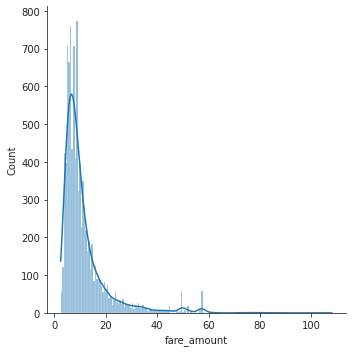

In [124]:
sns.displot(data=df, x="fare_amount", kde=True)

<AxesSubplot:>

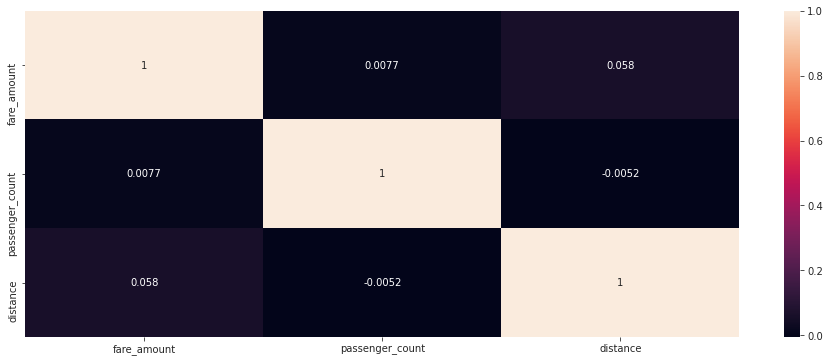

In [125]:
plt.figure(figsize=(16, 6))
sns.heatmap(df.corr(), annot=True)

<AxesSubplot:xlabel='distance', ylabel='fare_amount'>

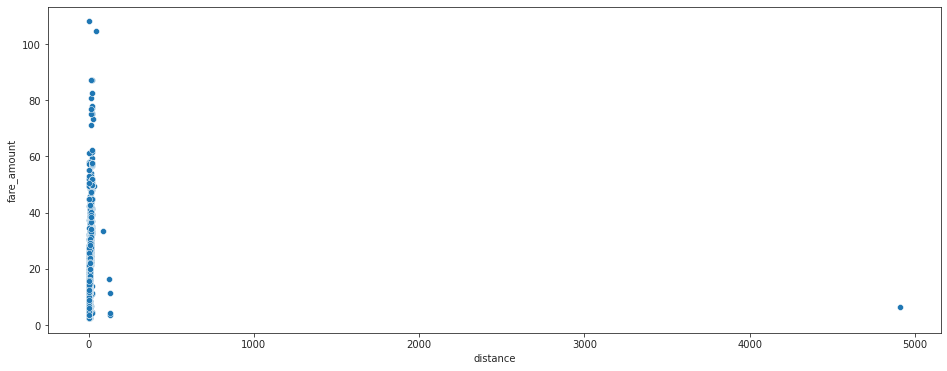

In [126]:
plt.figure(figsize=(16, 6))
sns.scatterplot(data=df, x="distance", y="fare_amount")